## Supervised learning assignemtn
##### Name: Daan Steur
##### Studentnumber: 379943
##### Supervisor: Drs. Bart Barnard
##### Course: DSLS Data Science 3: Supervised learning
##### Date: 27th of may

### Prediction of Blood Pressure Abnormality based on patient health information. 

#### Assignment 
Load, inspect and clean the data. Split the data into a training set and a validation set and a test set. Use a simple classifier as a baseline. Train various classifiers. Motivate your choice in relation to the characteristics of the dataset. Try to combine them into an ensemble learning model that outperforms all of the others

#### Data
Blood Pressure Data for disease Prediction
Patient_Number
 - Blood_Pressure_Abnormality
 - Level_of_Hemoglobin
 - Genetic_Pedigree_Coefficient
 - Age
 - BMI
 - Sex
 - Pregnancy
 - Smoking
 - Physical_activity
 - salt_content_in_the_diet
 - alcohol_consumption_per_day
 - Level_of_Stress
 - Chronic_kidney_disease
 - Adrenal_and_thyroid_disorders

Data & packages

In [253]:
# load packages
# base
import pandas as pd
import numpy as np
import collections
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from matplotlib import pyplot
# stats
import scipy.stats as stats
import statsmodels.api as sm
from exploration import *
# Modeling
from sklearn import tree, preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier


In [254]:
# load data
data = pd.read_csv("data.csv")
# drop parient ids
data.drop(['Patient_Number'], axis=1, inplace=True)
# reoreder columns
data = data[["Blood_Pressure_Abnormality",
            "Chronic_kidney_disease",
             "Adrenal_and_thyroid_disorders",
             "Level_of_Hemoglobin",
             "Genetic_Pedigree_Coefficient",
             "Age",
             "BMI",
             "Sex",
             "Pregnancy",
             "Smoking",
             "Physical_activity",
             "salt_content_in_the_diet",
             "alcohol_consumption_per_day",
             "Level_of_Stress",
]]
data["Sex"] =  data["Sex"].replace({1: "male", 0: "female"})
data["Chronic_kidney_disease"] =  data["Chronic_kidney_disease"].replace({1: "diseased", 0: "healthy"})
data["Adrenal_and_thyroid_disorders"] =  data["Adrenal_and_thyroid_disorders"].replace({1: "diseased", 0: "healthy"})
data["Blood_Pressure_Abnormality"] =  data["Blood_Pressure_Abnormality"].replace({1: "diseased", 0: "healthy"})
data["Smoking"] =  data["Smoking"].replace({1: "yes", 0: "no"})
data.head()

,Blood_Pressure_Abnormality,Chronic_kidney_disease,Adrenal_and_thyroid_disorders,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress
0,diseased,diseased,diseased,11.28,0.90,34,23,male,1.0,no,45961,48071,NaN,2
1,healthy,healthy,healthy,9.75,0.23,54,33,male,NaN,no,26106,25333,205.0,3
2,diseased,diseased,healthy,10.79,0.91,70,49,female,NaN,no,9995,29465,67.0,2
3,healthy,diseased,healthy,11.00,0.43,71,50,female,NaN,no,10635,7439,242.0,1
4,diseased,healthy,healthy,14.17,0.83,52,19,female,NaN,no,15619,49644,397.0,2


Data Exploration (EDA)

c:\Users\31613\Desktop\Git repositories\DSLS-DS3-Machine-learning\Supervised-learning\exploration.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.sort_index(axis=1, inplace=True, key=lambda x: x.str.lower())


                             N Obs    N Missing    N Valid    % Complete    N Unique      Mean        SD    Median       MAD    Min       Max    Skewness    Kurtosis  CV
-------------------------  -------  -----------  ---------  ------------  ----------  --------  --------  --------  --------  -----  --------  ----------  ----------  ----
Age                           2000            0       2000         100            58     46.56     17.11     46        22.24   18       75           0.02       -1.25  0.37
alcohol_consumption_per_d     2000          242       1758          87.9         488    251.01    143.65    250       186.81    0      499          -0.01       -1.22
BMI                           2000            0       2000         100            41     30.08     11.76     30        14.83   10       50          -0.02       -1.18  0.39
Genetic_Pedigree_Coeffici     2000           92       1908          95.4         101      0.49      0.29      0.49      0.37    0        1          

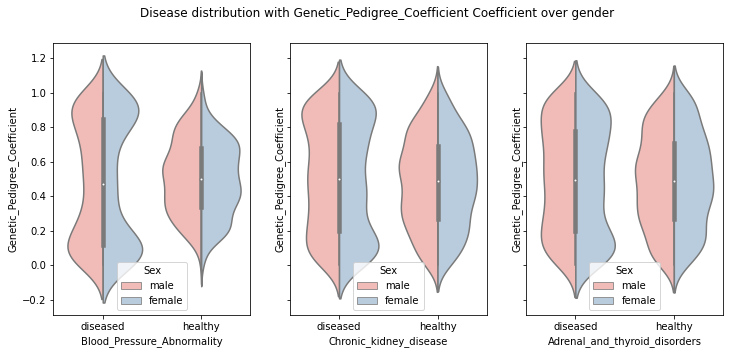

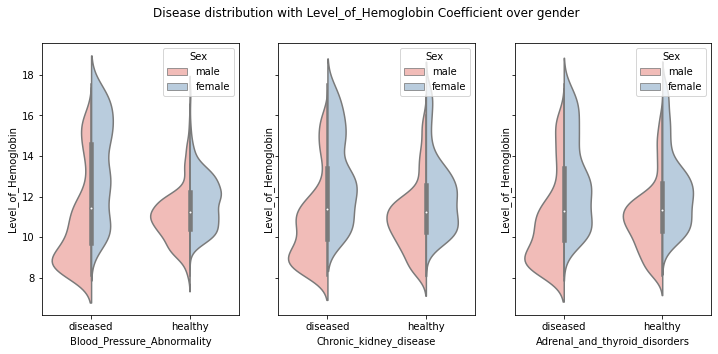

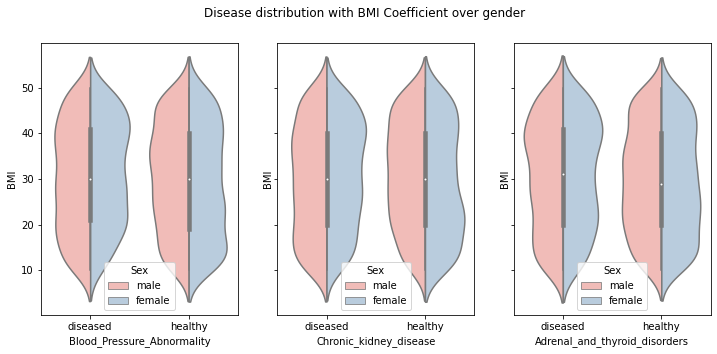

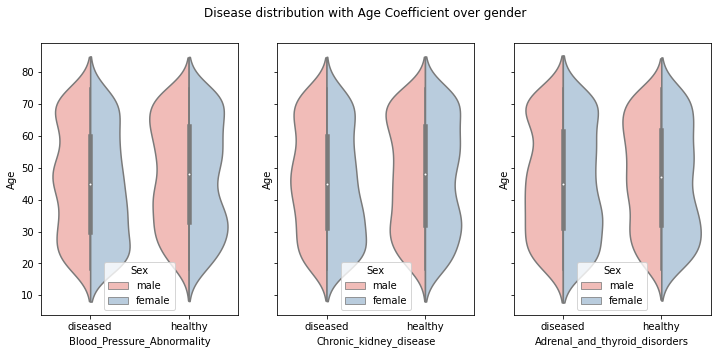

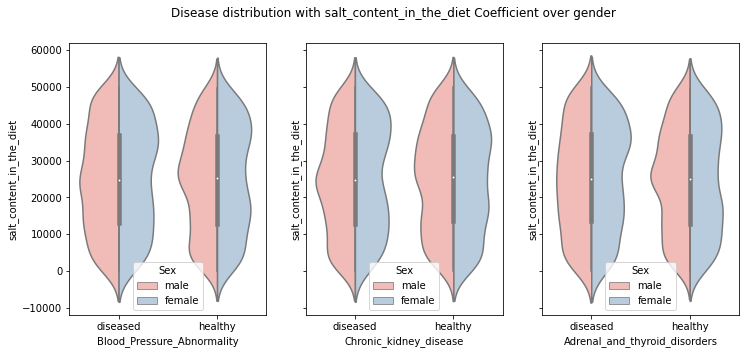

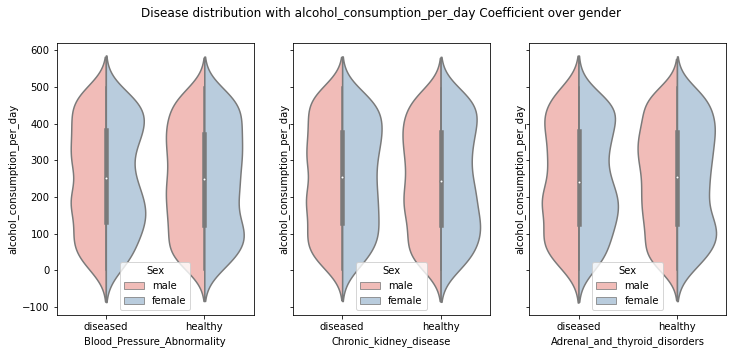

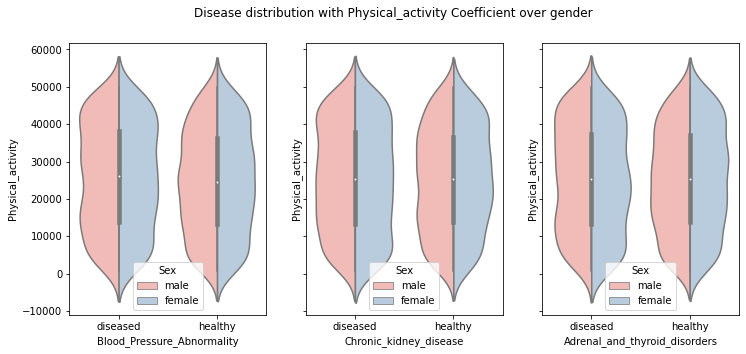

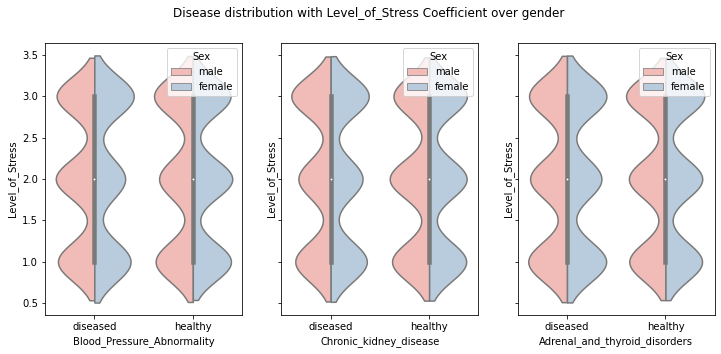

In [255]:
# overview of data
exploration.data_exploration_csv("data.csv")
exploration.Categorical_Variables_csv("data.csv")

labels = [["Genetic_Pedigree_Coefficient", "Level_of_Hemoglobin", "BMI", "Age", "salt_content_in_the_diet", "alcohol_consumption_per_day", "Physical_activity", "Level_of_Stress"]]


for label in labels:
    for i in label:
        exploration.violin_plot(i, data)

# exploration.violin_plot("Genetic_Pedigree_Coefficient", data)

# exploration.violin_plot("Age", data)

# exploration.violin_plot("Level_of_Hemoglobin", data)

# exploration.violin_plot("BMI", data)


<AxesSubplot:>

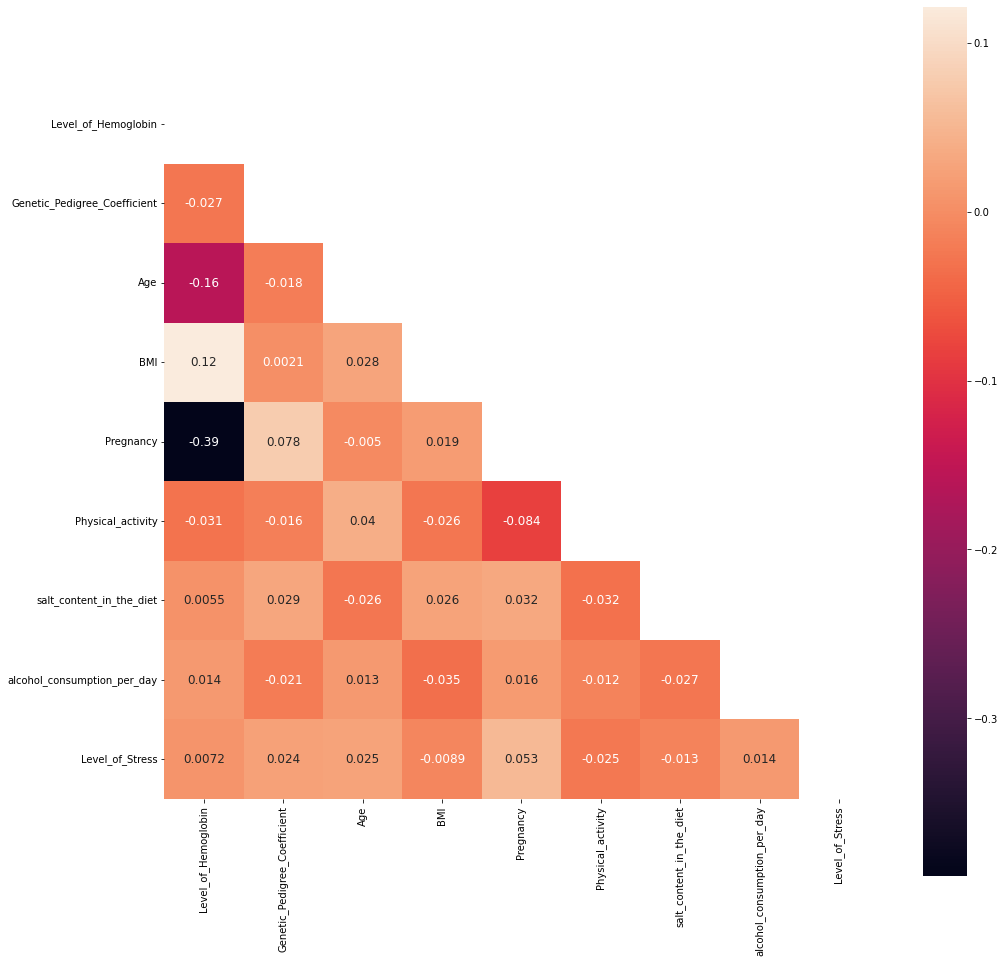

In [256]:
# drop rows with na values
data = data.dropna(subset=["Genetic_Pedigree_Coefficient","alcohol_consumption_per_day"])

# Calculate correlation between each pair of variable
corr_matrix=data.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
plt.figure(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 12}, square=True, mask=mask)

### model selection

In [257]:
data.head()

,Blood_Pressure_Abnormality,Chronic_kidney_disease,Adrenal_and_thyroid_disorders,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress
1,healthy,healthy,healthy,9.75,0.23,54,33,male,NaN,no,26106,25333,205.0,3
2,diseased,diseased,healthy,10.79,0.91,70,49,female,NaN,no,9995,29465,67.0,2
3,healthy,diseased,healthy,11.00,0.43,71,50,female,NaN,no,10635,7439,242.0,1
4,diseased,healthy,healthy,14.17,0.83,52,19,female,NaN,no,15619,49644,397.0,2
6,diseased,diseased,diseased,11.69,0.75,43,41,male,1.0,no,38369,32967,206.0,3


In [258]:
# organise data
label_names = ['Blood_Pressure_Abnormality']
labels = data[label_names].to_numpy()
feature_names = ['Genetic_Pedigree_Coefficient', 'Age', 'BMI','Level_of_Stress', 'salt_content_in_the_diet', 'alcohol_consumption_per_day','Physical_activity','Level_of_Hemoglobin']
features = data[feature_names].to_numpy()

print(label_names)
print(labels[0])
print(feature_names[0])
print(features[0])

train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)


['Blood_Pressure_Abnormality']
['healthy']
Genetic_Pedigree_Coefficient
[2.3000e-01 5.4000e+01 3.3000e+01 3.0000e+00 2.5333e+04 2.0500e+02
 2.6106e+04 9.7500e+00]


>lr 0.510 (0.036)
>knn 0.494 (0.037)
>cart 0.826 (0.036)
>svm 0.510 (0.029)
>bayes 0.698 (0.030)


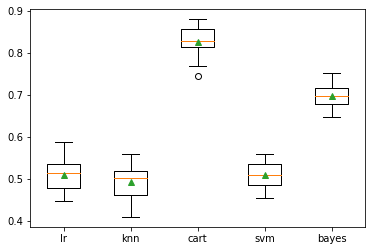

In [259]:
# get a list of models to evaluate
from sklearn import preprocessing

def get_models():
	models = {'lr': LogisticRegression()}
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	return cross_val_score(
	    model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 
# define dataset
X = train
y = train_labels

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()



### Naïve Bayes Classifier
Naïve Bayes is a classification technique used to build classifier using the Bayes theorem. The assumption is that the predictors are independent. In simple words, it assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature

In [260]:
# naive base model
gnb = GaussianNB()
model = gnb.fit(train, train_labels)
preds = gnb.predict(test)
# print(preds[:25])

print(accuracy_score(test_labels, preds))
print(confusion_matrix(test_labels, preds))
print(classification_report(test_labels, preds))


0.7172619047619048
[[ 92  71]
 [ 24 149]]
              precision    recall  f1-score   support

    diseased       0.79      0.56      0.66       163
     healthy       0.68      0.86      0.76       173

    accuracy                           0.72       336
   macro avg       0.74      0.71      0.71       336
weighted avg       0.73      0.72      0.71       336



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Decision Tree Classifier
A decision tree is basically a binary tree flowchart where each node splits a group of observations according to some feature variable

In [261]:

cart = DecisionTreeClassifier()
model = cart.fit(train, train_labels)
preds = cart.predict(test)
# print(preds[:25])

print(accuracy_score(test_labels, preds))
confusion_matrix = confusion_matrix(test_labels, preds)
print(confusion_matrix)
print(classification_report(test_labels, preds))

0.8273809523809523
[[139  24]
 [ 34 139]]
              precision    recall  f1-score   support

    diseased       0.80      0.85      0.83       163
     healthy       0.85      0.80      0.83       173

    accuracy                           0.83       336
   macro avg       0.83      0.83      0.83       336
weighted avg       0.83      0.83      0.83       336



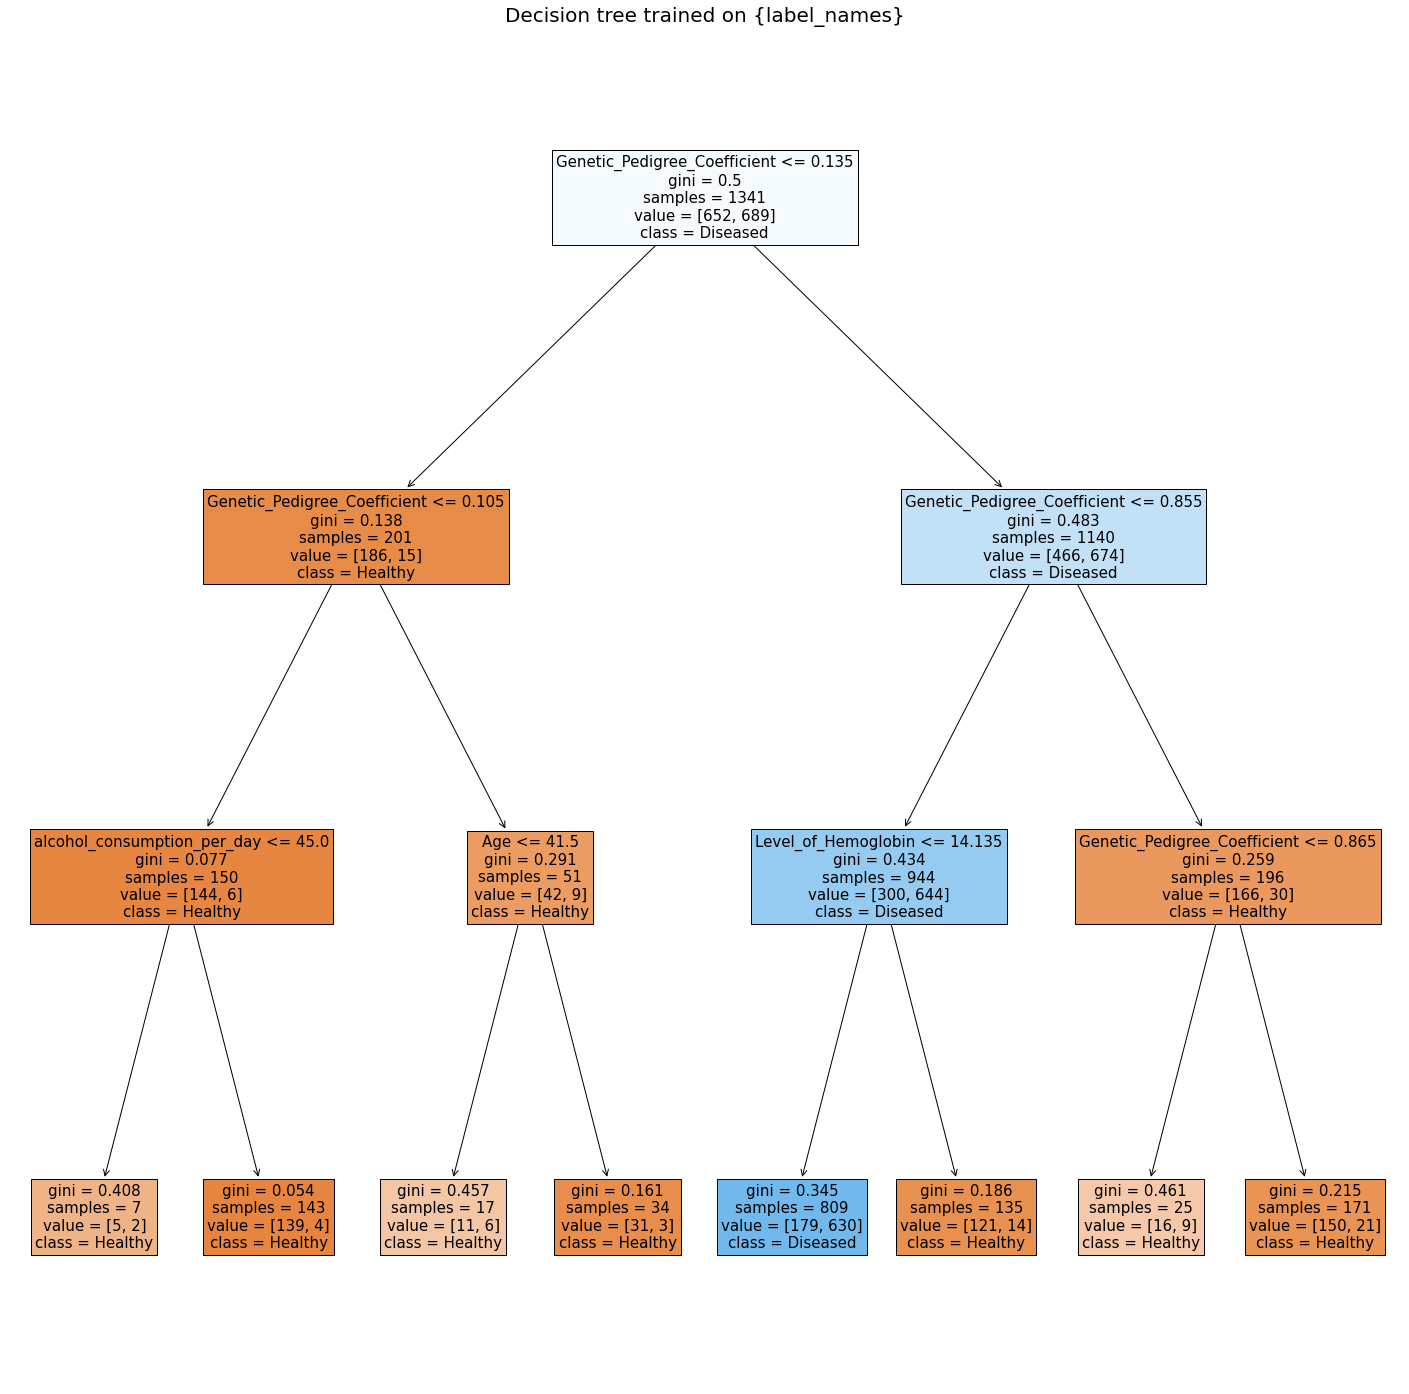

In [262]:
labels = ['Healthy', 'Diseased']
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
clf = clf.fit(X, y)
plt.figure(figsize=(25,25))
tree.plot_tree(clf, filled=True, fontsize=15, label='all',feature_names=feature_names, class_names=labels)
plt.title("Decision tree trained on {label_names}", fontsize=20)
plt.show()


#### Stacking models

Stacking or Stacked Generalization is an ensemble machine learning algorithm.
It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.
The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

model lr accuracy: 0.510  (0.036)
model knn accuracy: 0.494  (0.037)
model cart accuracy: 0.831  (0.035)
model svm accuracy: 0.510  (0.029)
model bayes accuracy: 0.698  (0.030)
model stacking accuracy: 0.834  (0.031)


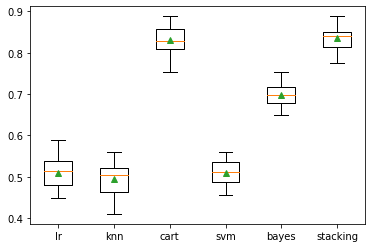

In [263]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = [('lr', LogisticRegression())]
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
 
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = {'lr': LogisticRegression()}
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	return cross_val_score(
	    model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 
# define dataset
X = train
y = train_labels
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('model %s accuracy: %.3f  (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()



TypeError: unhashable type: 'numpy.ndarray'

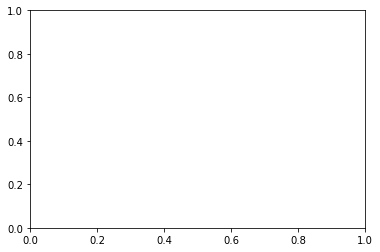

In [264]:
plt.scatter(train, train_labels, color = "red")
plt.plot(train, preds, color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()